In [4]:
import glob
import os
import datetime
import numpy as np
import pytz
import gpxpy
import shutil
import cmocean
import GPX_functions
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import logging
from pyproj import Proj, transform
from importlib import reload
reload(GPX_functions)
plt.style.use('dark_background')
plt.rcParams.update({'font.size': 22})

In [5]:
from matplotlib.font_manager import FontProperties
fontfile = "/home/ctroupin/.fonts/D-DIN.ttf"
myfont = FontProperties(fname=fontfile)
mycolor1 = "#fb8500"
mycolor1b = "#ffb703"
mycolor2 = "#219ebc"

In [6]:
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logging.info("Starting")

INFO:root:Starting


In [7]:
figdir = "../images/Sleeping/"
if not os.path.exists(figdir):
    os.makedirs(figdir)
datafilelist = sorted(glob.glob(os.path.join("/data/GPX/Moves/gpx/Verviers/", "*.gpx")))
outputdir = "/data/GPX/Sleeping/"
mycolor = "#FF963D"
logger.info("Found {} files".format(len(datafilelist)))

INFO:root:Found 705 files


In [8]:
t0list = []
dlist = []
lonall = np.array([])
latall = np.array([])
eleall = np.array([])
speedall = np.array([])
lonmean = np.array([])
latmean = np.array([])
iii = 0
for datafile in datafilelist:
    lon, lat, ele, t = GPX_functions.read_gpx(datafile)
    try:
        t0 = t[0]
        
        if t0.hour >= 17.:
            
            dist = GPX_functions.compute_dist(lon, lat)
            deltatime = t[1:] - t[0:-1]
            deltatime_s = [dddd.total_seconds() for dddd in deltatime]
            deltatime_s = np.array(deltatime_s)
            
            # Compute speed (in km/h)
            deltatime = t[-1] - t[0]
            meanspeed = dist.sum() / (deltatime.total_seconds() / 3600.)
            
            # Discard tracks longer than 7 km or faster than 6 km/h
            if (dist.sum() < 7.) & (dist.sum() > 0.050) & (meanspeed < 6.):
                iii += 1
                lonall = np.append(lonall, lon)
                latall = np.append(latall, lat)
                eleall = np.append(eleall, ele)
                
                lonmean = np.append(lonmean, lon.mean())
                latmean = np.append(latmean, lat.mean())
                
                speed = dist[1:] / (deltatime_s / 3600.)
                speedall = np.append(speedall, 0.0)
                speedall = np.append(speedall, speed)

                t0list.append(t0)
                dlist.append(dist.sum())
                
                # Copy file to another directory
                shutil.copy2(datafile, outputdir)
                    
    except IndexError:
        logger.warning("No records in file {}".format(datafile))
logger.info(f"{iii} tracks after 6PM")

INFO:root:164 tracks after 6PM


In [9]:
daylist = [(tt  - datetime.datetime(1970,1,1, tzinfo=pytz.utc)).days for tt in t0list]
xticklist = [datetime.datetime(2020, mm, 1) for mm in range(8, 13)]
xticklist2 = [datetime.datetime(2021, mm, 1) for mm in range(1, 5)]
xticklist = [*xticklist, *xticklist2]
xticks = [(tt  - datetime.datetime(1970,1,1)).days for tt in xticklist]

In [11]:
import cartopy
import cartopy.crs as ccrs
import contextily as ctx
import configparser
import hikinggc

config = configparser.ConfigParser()
config.read("/etc/config.txt")
apikey = config.get("configuration", "thunderkey")
basemap = ctx.providers.Thunderforest.OpenCycleMap
basemap = ctx.providers.CartoDB["DarkMatterNoLabels"]
basemap["url"] = "https://{s}.tile.thunderforest.com/outdoors/{z}/{x}/{y}.png?apikey=%s" %(apikey)
proj = ccrs.epsg(3857)
basemap

{'url': 'https://{s}.tile.thunderforest.com/outdoors/{z}/{x}/{y}.png?apikey=ae9ca0847f82405693ead4840c01ad17',
 'attribution': '(C) OpenStreetMap contributors (C) CARTO',
 'subdomains': 'abcd',
 'max_zoom': 19,
 'variant': 'dark_nolabels',
 'name': 'CartoDB.DarkMatterNoLabels'}

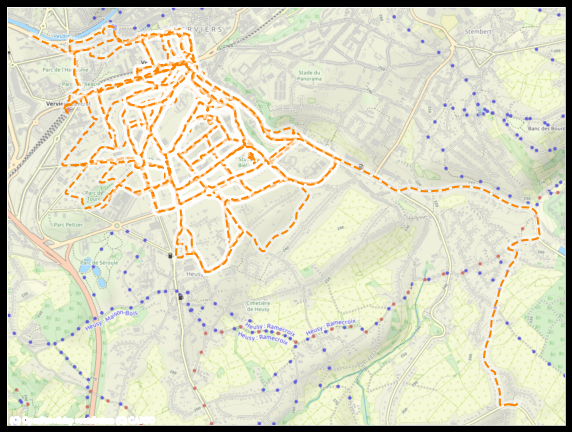

In [12]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=proj)

for iii, datafile in enumerate(datafilelist):
    lon, lat, ele, t = GPX_functions.read_gpx(datafile)
    try:
        t0 = t[0]
        
        if t0.hour >= 17.:
            dist = GPX_functions.compute_dist(lon, lat)
            if dist.sum() < 6.:
                track = hikinggc.Track()
                track.get_coords(datafile)
                track.add_track(ax, color=mycolor1)
    except IndexError:
        logger.warning("No records in file {}".format(datafile))

if basemap is not None:
    ctx.add_basemap(ax, source=basemap, origin='upper')

# Add map scale
#hikinggc.scale_bar(ax, location=(0.15, 0.05), length=1)

ax.set_xticks([])
ax.set_yticks([])

plt.savefig(os.path.join(figdir, "sleeping08.jpg"), dpi=300, bbox_inches="tight")
plt.show()
plt.close()

In [13]:
track0 = hikinggc.Track()
track0.lon = lonall
track0.lat = latall

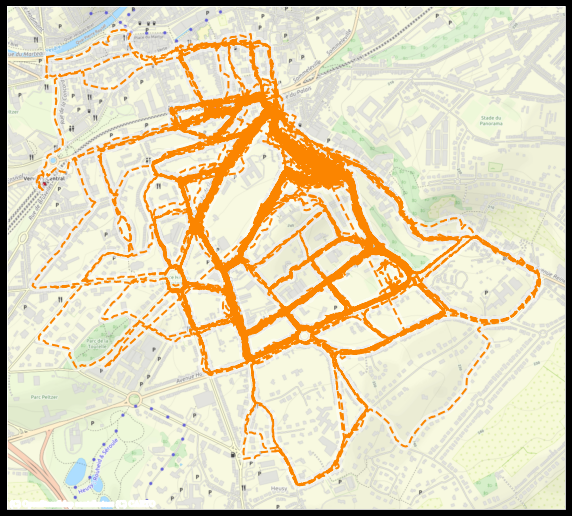

In [16]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=proj)

track0.add_track(ax, color=mycolor1)
if basemap is not None:
    ctx.add_basemap(ax, source=basemap, origin='upper')


ax.set_xticks([])
ax.set_yticks([])

plt.savefig(os.path.join(figdir, "sleeping09.jpg"), dpi=300, bbox_inches="tight")
plt.show()
plt.close()